Epoch 1/10
469/469 [==============================] - 13s 24ms/step - loss: 0.0678 - val_loss: 0.0572
Epoch 2/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0555 - val_loss: 0.0538
Epoch 3/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0529 - val_loss: 0.0513
Epoch 4/10
469/469 [==============================] - 9s 18ms/step - loss: 0.0500 - val_loss: 0.0482
Epoch 5/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0475 - val_loss: 0.0463
Epoch 6/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0457 - val_loss: 0.0447
Epoch 7/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0447 - val_loss: 0.0439
Epoch 8/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0441 - val_loss: 0.0433
Epoch 9/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0436 - val_loss: 0.0429
Epoch 10/10
313/313 [==============================] - 1s 3ms/step


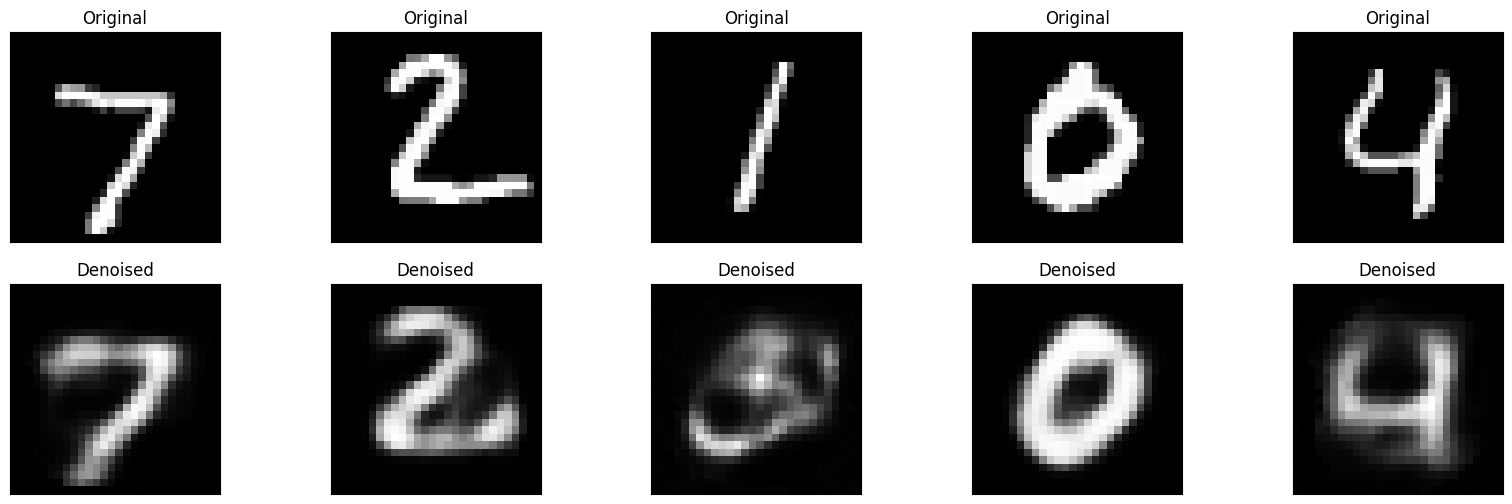

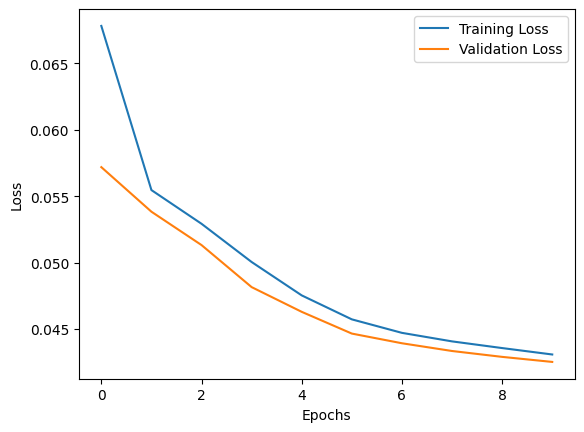

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse

# MNIST veri setini yükleyin
(x_train, _), (x_test, _) = mnist.load_data()

# Giriş görüntülerini normalleştirin ve yeniden şekillendirin
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)


# latent katmanının boyutlarını ayarlayın
latent_dim = 140

# Encoder mimarisini tanımlayın
input_img = Input(shape=(784,))
hidden = Dense(256, activation='relu')(input_img)
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# latent katmanı için sampling fonksiyonu tanımlayın
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))  #latent katmanı için varyans ve ortalama değerlerin hesaplayın
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder mimarisini tanımlayın
decoder_hidden = Dense(256, activation='relu')(z)
output_img = Dense(784, activation='sigmoid')(decoder_hidden)

# VAE MODELİNİ TANIMLAYIN
vae = Model(input_img, output_img)

# KAYIP FONKSİYONUNU TANIMLAYIN
reconstruction_loss = mse(input_img, output_img)
kl_loss = -0.1 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# VAE MODELİNİ EĞİTEREK HİSTORY DEĞİŞKENİNDE SAKLAYIN saklayın
history = vae.fit(x_train, epochs=10, batch_size=128, validation_data=(x_test, None))

# Test Görüntüleri üzerine beyaz gürültü ekleyin
noise_factor = 0.1
stddev = 0.001
noise = np.random.randn(*x_test.shape) * stddev + noise_factor
x_test_noisy = np.clip(x_test + noise, 0.0, 1.0)


# Beyaz görültü eklenmiş gürültüyü Eğitmiş olduğumuz VAE MODELİNE UYGULAYARAK ÇIKTIYI TAHMİN EDİN
decoded_imgs = vae.predict(x_test_noisy)

# ORJİNAL VE BEYAZ GÜRÜLTÜSÜ GİDERİLMİŞ GÖRÜNTÜLERİ GÖRÜNTÜLEYİN.
n = 5  # 5 ADET TEST GÖRÜNTÜSÜ İÇİN BU İŞLEMİ UYGULAYIN.
plt.figure(figsize=(20,6))
for i in range(n):
    # ORJİNAL FOTOĞRAF
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # GÜRÜLTÜSÜ GİDERİLMİŞ FOTĞRAFLAR
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title('Denoised')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Sonuçta Elde Edilen Çıktı Görüntülerini Göster
plt.show()

# Kayıp Grafiğini Çizdir.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
